<a href="https://colab.research.google.com/github/Haripofficial/Final-project/blob/main/Word2vec_presentation_model_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MENTAL HEALTH CHATBOT USING SENTIMENT ANALYSIS

## *LSTM Model Using Word2vec*


*   For sentiment analysis we need to deal with sequential data where the context of a word have greater importance. Hence we select LSTM Model. They are a special kind of RNN, capable of learning long-term dependencies.









In [ ]:
# importing different libraries requred for building and evaluating the model.
# pandas 
import pandas as pd

# nltk - natural language toolkit
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Word2vec
import gensim

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# others
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:


# Details of the dataset
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# Text cleaning
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Word2vec config
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Parameters for lstm
SEQUENCE_LENGTH = 30
EPOCHS = 15
BATCH_SIZE = 1024

# Sentiment Assigning
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

# Modal download
KERAS_MODEL = "modelvs.h5"
WORD2VEC_MODEL = "modelvs.w2v"
TOKENIZER_MODEL = "tokenizerfinalvs.pkl"
ENCODER_MODEL = "encodervs.pkl"

In [ ]:
#dataset_filename = os.listdir("../input")[0]
#dataset_path = os.path.join("..","input",dataset_filename)
#print("Open file:", dataset_path)
df = pd.read_csv('/content/drive/MyDrive/Dataset/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 480 ms, sys: 2.91 ms, total: 483 ms
Wall time: 483 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

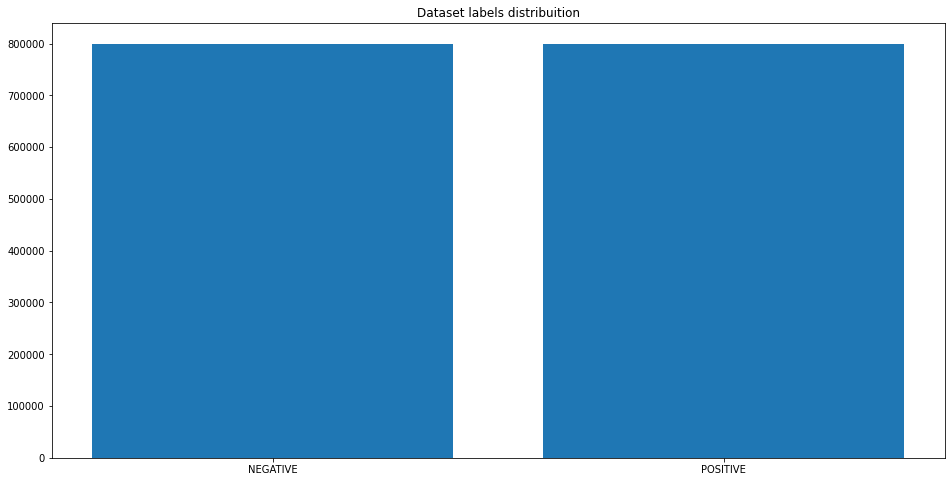

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
neg = ['not','no','don',"don't",'off','should',"aren't" , 't', 'can', 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'ain', 'aren']
Stop_words = [e for e in stop_words if e not in neg]
print(Stop_words)
stemmer = SnowballStemmer("english")

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'e

In [ ]:
def preprocess(text, stem=False):
    text=text.replace("'",'')
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in Stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
 

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 38.8 s, sys: 221 ms, total: 39.1 s
Wall time: 39.1 s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.71 s, sys: 320 ms, total: 3.03 s
Wall time: 3.03 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2021-06-05 17:18:40,884 : INFO : collecting all words and their counts
2021-06-05 17:18:40,885 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-05 17:18:40,910 : INFO : PROGRESS: at sentence #10000, processed 77345 words, keeping 14156 word types
2021-06-05 17:18:40,933 : INFO : PROGRESS: at sentence #20000, processed 153988 words, keeping 21803 word types
2021-06-05 17:18:40,958 : INFO : PROGRESS: at sentence #30000, processed 230195 words, keeping 27837 word types
2021-06-05 17:18:40,977 : INFO : PROGRESS: at sentence #40000, processed 307559 words, keeping 33135 word types
2021-06-05 17:18:41,001 : INFO : PROGRESS: at sentence #50000, processed 383861 words, keeping 38054 word types
2021-06-05 17:18:41,023 : INFO : PROGRESS: at sentence #60000, processed 460279 words, keeping 42714 word types
2021-06-05 17:18:41,046 : INFO : PROGRESS: at sentence #70000, processed 536692 words, keeping 47041 word types
2021-06-05 17:18:41,065 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30737


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-06-05 17:18:49,286 : INFO : training model with 8 workers on 30737 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-06-05 17:18:50,325 : INFO : EPOCH 1 - PROGRESS: at 4.48% examples, 377834 words/s, in_qsize 13, out_qsize 4
2021-06-05 17:18:51,333 : INFO : EPOCH 1 - PROGRESS: at 9.47% examples, 402796 words/s, in_qsize 15, out_qsize 3
2021-06-05 17:18:52,339 : INFO : EPOCH 1 - PROGRESS: at 14.45% examples, 411272 words/s, in_qsize 16, out_qsize 0
2021-06-05 17:18:53,371 : INFO : EPOCH 1 - PROGRESS: at 19.51% examples, 415067 words/s, in_qsize 12, out_qsize 3
2021-06-05 17:18:54,410 : INFO : EPOCH 1 - PROGRESS: at 24.70% examples, 418399 words/s, in_qsize 13, out_qsize 3
2021-06-05 17:18:55,488 : INFO : EPOCH 1 - PROGRESS: at 30.08% examples, 420933 words/s, in_qsize 13, out_qsize 5
2021-06-05 17:18:56,518 : INFO : EPOCH 1 - PROGRESS: at 35.15% examples, 422802 words/s, in_qsize 16, out_qsize 6
2021-06-05 17:18:57,529 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 20min 24s, sys: 6.82 s, total: 20min 31s
Wall time: 10min 35s


(277125557, 314829696)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-06-05 17:29:24,803 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5866920351982117),
 ('adore', 0.5491572022438049),
 ('loves', 0.5378339290618896),
 ('loved', 0.5090295672416687),
 ('amazing', 0.5080989003181458),
 ('lovee', 0.4910221993923187),
 ('looove', 0.4869469702243805),
 ('loveee', 0.4788251519203186),
 ('awesome', 0.458760142326355),
 ('loooove', 0.4512588381767273)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 295348
CPU times: user 15.3 s, sys: 197 ms, total: 15.5 s
Wall time: 15.4 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)
CPU times: user 22.4 s, sys: 398 ms, total: 22.8 s
Wall time: 22.6 s


In [ ]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 30)
y_train (1280000, 1)

x_test (320000, 30)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(295348, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-06-05 17:30:10,279 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           88604400  
_________________________________________________________________
dropout (Dropout)            (None, 30, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 88,764,901
Trainable params: 160,501
Non-trainable params: 88,604,400
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
1125/1125 [==============================] - 88s 58ms/step - loss: 0.5072 - accuracy: 0.7485 - val_loss: 0.4402 - val_accuracy: 0.7984
Epoch 2/15
1125/1125 [==============================] - 64s 57ms/step - loss: 0.4512 - accuracy: 0.7874 - val_loss: 0.4255 - val_accuracy: 0.8053
Epoch 3/15
1125/1125 [==============================] - 64s 57ms/step - loss: 0.4409 - accuracy: 0.7930 - val_loss: 0.4185 - val_accuracy: 0.8089
Epoch 4/15
1125/1125 [==============================] - 64s 57ms/step - loss: 0.4358 - accuracy: 0.7956 - val_loss: 0.4155 - val_accuracy: 0.8100
Epoch 5/15
1125/1125 [==============================] - 63s 56ms/step - loss: 0.4329 - accuracy: 0.7975 - val_loss: 0.4151 - val_accuracy: 0.8111
Epoch 6/15
1125/1125 [==============================] - 63s 56ms/step - loss: 0.4308 - accuracy: 0.7989 - val_loss: 0.4120 - val_accuracy: 0.8123
Epoch 7/15
1125/1125 [==============================] - 63s 56ms/step - loss: 0.4287 - accuracy: 0.8004 - val_loss: 0.4119 -

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 7s 20ms/step - loss: 0.4058 - accuracy: 0.8147

ACCURACY: 0.814662516117096
LOSS: 0.4058171212673187
CPU times: user 6.57 s, sys: 207 ms, total: 6.78 s
Wall time: 6.98 s


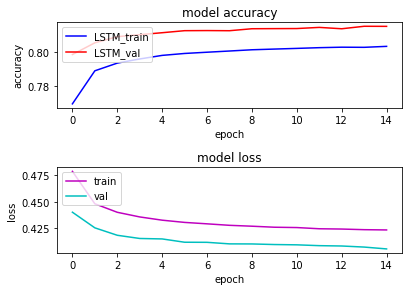

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.7)

In [ ]:
def decode_sentiment(score):
    return POSITIVE if score>0.5 else NEGATIVE

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

40/40 [==============================] - 5s 108ms/step
CPU times: user 5.59 s, sys: 321 ms, total: 5.91 s
Wall time: 5.6 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

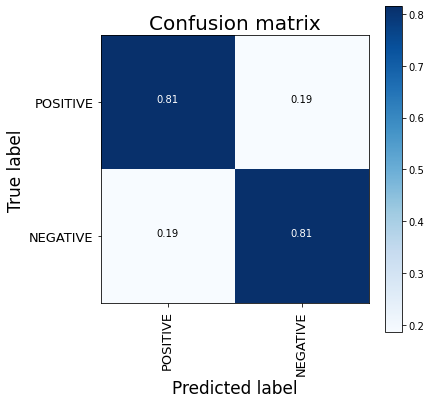

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.81      0.81    159494
    POSITIVE       0.82      0.81      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.8146625

In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)
    return { "score": float(score)}
    #return { "score": float(score),
   

In [ ]:
predict("feeling good")

{'score': 0.944380521774292}

In [ ]:
predict("I hate the rain")

{'score': 0.008667835965752602}

In [ ]:
predict("does sounds good")

{'score': 0.9837750792503357}

In [ ]:
predict("i don't know what i'm doing")

{'score': 0.31240713596343994}

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-06-05 17:46:32,781 : INFO : saving Word2Vec object under modelvs.w2v, separately None
2021-06-05 17:46:32,783 : INFO : not storing attribute vectors_norm
2021-06-05 17:46:32,787 : INFO : not storing attribute cum_table
2021-06-05 17:46:33,474 : INFO : saved modelvs.w2v
